Il s'agit d'un notebook à propos de la *Machine translation* écrit par Yann MUNRO dans le cadre du cours "Algorithms in Machine Learning" de l'ISAE-SUPAERO

Avant de commencer l'exécution de ce notebook, je vous recommande de l'ouvrir sur Colab' afin de pouvoir profiter du GPU mais également ne pas s'embêter avec le téléchargement de toutes les librairies à savoir:

- Pytorch
- nltk
- transformers

Pour passer en mode GPU, il suffit d'aller dans le menu "Exécution" -> "Modifier le type d'exécution" -> Choisir GPU  

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import random
import os
import numpy as np

In [3]:
import nltk
nltk.download('book')
nltk.download('comtrans')
from nltk.corpus import comtrans
from nltk import word_tokenize
from nltk.translate import Alignment, AlignedSent

[nltk_data] Downloading collection 'book'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/abc.zip.
[nltk_data]    | Downloading package brown to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/brown.zip.
[nltk_data]    | Downloading package chat80 to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/chat80.zip.
[nltk_data]    | Downloading package cmudict to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/cmudict.zip.
[nltk_data]    | Downloading package conll2000 to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/conll2000.zip.
[nltk_data]    | Downloading package conll2002 to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/conll2002.zip.
[nltk_data]    | Downloading package dependency_treebank to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping corpora/dependency_treebank.zip.
[nltk_data]    | Downloading package genesis to /root/nltk_data...
[nltk_data]    

In [4]:
#Pour importer les données si vous utilisez Google Colab, sinon vous pouvez les télécharger directement depuis le github 
!git clone https://github.com/SupaeroDataScience/deep-learning.git

Cloning into 'deep-learning'...
remote: Enumerating objects: 6994, done.
remote: Total 6994 (delta 0), reused 0 (delta 0), pack-reused 6994
Receiving objects: 100% (6994/6994), 95.60 MiB | 19.84 MiB/s, done.
Resolving deltas: 100% (2965/2965), done.
Checking out files: 100% (6400/6400), done.


In [5]:
os.chdir('deep-learning/NLP')
data_path = 'datasets/enfratexts.txt'

In [6]:
#setting up device for use with pyTorch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("device used is ",device)

device used is  cuda


#Effective Approaches to Attention based neural machine translation

[Lien](https://arxiv.org/pdf/1508.04025.pdf) de l'article

## Importation du dataset

Il s'agit du même dataset que celui utilisé dans les différents notebooks du cours de NLP mais aussi un tuturiel pytorch (lien section RNN).

Pour les détails, je vous renvoie directement à eux.

In [7]:
# Start and end sequence tokens
Start_sentence_token = 1
End_sentence_token = 0


#Class defining a language.
class Lang:
    def __init__(self, name):
        self.name = name
        self.word2index = {}#Contains the index of each word in the dictionnary
        self.word2count = {}#Contains the count of each word
        self.index2word = {1: "SOS", 0: "EOS"} #Reverse lookup table for words (useful for decoding sentences back to a readable form)
        self.n_words = 2  # Count SOS and EOS

    def addSentence(self, sentence):
        for word in sentence.split(' '):
            self.addWord(word)

    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1
            
            
## UTILS
import re, unicodedata

# Convert to ASCII (because of french sentences)
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
    )

# Trim, lowercase sentences and remove special chracters except punctuation
def normalizeString(s):
    s = unicodeToAscii(s.lower().strip())
    s = re.sub(r"([.!?])", r" \1", s)
    s = re.sub(r"[^a-zA-Z.!?]+", r" ", s)
    return s

# Filter data to keep only some relevant pairs. In particular, to ensure that the system trains fast enough,
# we define a max length for sequences and keep only sentences sentences that start the same.
max_length = 10

eng_prefixes = (
    "i am ", "i m ",
    "he is", "he s ",
    "she is", "she s ",
    "you are", "you re ",
    "we are", "we re ",
    "they are", "they re "
)

def filterPair(p):
    return len(p[0].split(' ')) < max_length and len(p[1].split(' ')) < max_length and p[0].startswith(eng_prefixes)
def filterPairs(pairs):
    return [pair for pair in pairs if filterPair(pair)]


# Reading, Normalizing data
def readLangs(lang1, lang2):
    print("Reading lines...")
    # Read the file and split into lines
    lines = open(data_path, encoding='utf-8').read().strip().split('\n')

    # Split every line into pairs and normalize
    pairs = [[normalizeString(s) for s in l.split('\t')] for l in lines]
    
    # Create language objects
    input_lang = Lang(lang1)
    output_lang = Lang(lang2)

    return input_lang, output_lang, pairs

# Full pipeline for importing data :
# Reads the files, and cleans data
# Filters pairs of english/french sentences to keep only those that are short enough and start the same
def prepareData(lang1, lang2):
    input_lang, output_lang, pairs = readLangs(lang1, lang2)
    print("Read %s sentence pairs" % len(pairs))
    pairs = filterPairs(pairs)
    print("Filtered to %s sentence pairs" % len(pairs))
    for pair in pairs:
        input_lang.addSentence(pair[0])
        output_lang.addSentence(pair[1])
    print("Dictionnary size:")
    print(input_lang.name, input_lang.n_words)
    print(output_lang.name, output_lang.n_words)
    return input_lang, output_lang, pairs
  
input_lang, output_lang, pairs = prepareData('english', 'francais')
p=np.array(pairs)[:,0:2]

Reading lines...
Read 170651 sentence pairs
Filtered to 12761 sentence pairs
Dictionnary size:
english 3054
francais 4740


In [8]:
pair = random.choice(p)
en_token=word_tokenize(pair[0])
fr_token=word_tokenize(pair[1])
print(en_token)
print(fr_token)

['you', 're', 'no', 'fun', 'at', 'all', '.']
['t', 'es', 'vraiment', 'pas', 'marrant', '.']


Cette partie est nécessaire pour adapter le dataset au format requis pour le code dans la partie Approche statistique.

In [8]:
tokenized_stores = {'en_train': [], 'en_test': [], 'fr_train': [], 'fr_test': []}

i=0
for sentences in pairs:
  token_store_en = word_tokenize(sentences[0]) 
  token_store_fr = word_tokenize(sentences[1])
  
  tokenized_stores['en_train'].append(token_store_en)
  tokenized_stores['fr_train'].append(token_store_fr)

train_size = len(tokenized_stores['en_train'])
test_size = 100

ind_test=random.sample(range(0, train_size), test_size)
tokenized_stores['en_test']=list( tokenized_stores['en_train'][i] for i in ind_test)
tokenized_stores['fr_test']=list( tokenized_stores['fr_train'][i] for i in ind_test)

In [9]:
# Création du vocabulaire

en_words = {}
fr_words = {}

for key in tokenized_stores:
    if str(key)[0] == 'e':
        # Création de en_words
        for sentence in tokenized_stores[key]:
            for word in sentence:
                if word in en_words:
                    en_words[word] += 1
                else:
                    en_words[word] = 1
    else:
        # Création de fr_words
        for sentence in tokenized_stores[key]:
            for word in sentence:
                if word in fr_words:
                    fr_words[word] += 1
                else:
                    fr_words[word] = 1
                    
en_vocab = len(en_words)
fr_vocab = len(fr_words)

##Quelques rappels sur le traitement du langage

###N-grams

"Un n-gramm est une sous séquence de n éléments construite à partir d'une séquence donnée" ([Wikipédia](https://fr.wikipedia.org/wiki/N-gramme))


In [27]:
from nltk.book import *

*** Introductory Examples for the NLTK Book ***
Loading text1, ..., text9 and sent1, ..., sent9
Type the name of the text or sentence to view it.
Type: 'texts()' or 'sents()' to list the materials.
text1: Moby Dick by Herman Melville 1851
text2: Sense and Sensibility by Jane Austen 1811
text3: The Book of Genesis
text4: Inaugural Address Corpus
text5: Chat Corpus
text6: Monty Python and the Holy Grail
text7: Wall Street Journal
text8: Personals Corpus
text9: The Man Who Was Thursday by G . K . Chesterton 1908


In [32]:
def generate_ngrams(token, n):
    
    # tokens = [token for token in s.split(" ") if token != ""]   
    ngrams = zip(*[token[i:] for i in range(n)])
    
    return [" ".join(ngram) for ngram in ngrams]

nb_gram=3 #A changer selon vos envies
ngrams=generate_ngrams(text1.tokens,nb_gram)

In [35]:
ngrams[42:52]

['He was ever',
 'was ever dusting',
 'ever dusting his',
 'dusting his old',
 'his old lexicons',
 'old lexicons and',
 'lexicons and grammars',
 'and grammars ,',
 'grammars , with',
 ', with a']

### *Word embedding* ou plongement de mots

Il s'agit d'une méthode d'apprentissage de représentation des mots par un vecteur réel.

Cela pourrait être fait avec un simple codage ASCII des caractères ou des mots, mais cela ne permettrait pas de capturer le sens du mot lui-même.

Pour cela, il faut commencer par un *one-hot encoding* sur tout le vocabulaire. Cependant, cela amène à une très grande dimension d'entrée et pour des vecteurs d'entrées avec beaucoup de zéros. De plus, cela ignore complètement les liens qu'il pourrait y avoir entre les mots, tels que des synonymes ou bien d'un même champ lexical.

Pour tenter de résoudre ces problèmes, on peut faire appel à un réseau de neurones. C'est le cas par exemple de l'algorithme *word2vec* encore très utilisé aujourd'hui.

Avec  cette approche, le réseau de neurone est entrainé à prédire un mot à partir de son **contexte** ou vice-versa.

Ainsi, en intercalant au moins une couche cachée entre la couche d'entrée et de sortie et en récupérant la sortie de la dernière couche cachée réduisant la dimension (ou de tout autre couche cachée d'ailleurs), on obtient un vecteur de la taille de la dimension de sortie de cette couche. 

En entrainant le réseau complet, on a réussi à obtenir une représentation du mot initial ou du mot à prédire selon le sens choisi qui a une dimension inférieure à celle du vocabulaire et en plus prend en compte son contexte. 

De cette façon, on a créé un réseau capable d'encoder un mot, un **encoder**.

In [2]:
#Code adapté du tutoriel sur pytorch: https://pytorch.org/tutorials/beginner/nlp/word_embeddings_tutorial.html

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

torch.manual_seed(1)

In [11]:
word_to_ix = {"hello": 0, "world": 1, '!': 2, "how":3, "are":4, "you":5, "?":6}
embeds = nn.Embedding(7, 5)  # 7 words in vocab, 5 dimensional embeddings

mot="hello"

lookup_tensor = torch.tensor([word_to_ix[mot]], dtype=torch.long)
hello_embed = embeds(lookup_tensor)
print("Représentation du mot ",mot, "dans une forme compréhensible par le réseau",hello_embed)

tensor([[ 1.2966,  0.8738, -0.5603,  1.2858,  0.8168]],
       grad_fn=<EmbeddingBackward>)


In [8]:
print("Dimension en cas de one hot encode: ",len(word_to_ix))
print("Dimension réduite grâce à l'embedding: ", len(hello_embed[0]))

Dimension en cas de one hot encode:  7
Dimension réduite grâce à l'embedding:  5


## Une brève introduction au *machine translation*

La *machine translation* est le nom du domaine associé à la traduction automatique de texte d'une langue vers une autre. C'est un domaine très difficile en intelligence artificielle en raison de la complexité et de la diversité de chaque langue. Un autre problème bien résumé par la phrase suivante ne facilite pas non plus la tâche:

> "*The fact is that accurate translation requires background knowledge in order to resolve ambiguity and establish the content of the sentence.*" [ Artificial Intelligence, A Modern Approach, 3rd Edition, 2009](http://amzn.to/2wUZesr)

De plus, il n'existe pas une traduction meilleure que toutes les autres pour une phrase et un contexte donnée. Cette ambiguitée rend l'automatisation encore plus difficile, cette dernière cherchant à un déterminer une meilleure traduction au sens d'un critère défini.

A l'origine, des *rule-based systems* (moteurs de règles en français) étaient utilisés avant de passer à des méthodes statistiques jusqu'à récemment avec l'avènement du *deep learning* et l'utilisation de réseaux de neurones. Ces méthodes appelées *Neural Machine Translation* forment aujourd'hui l'état de l'art dans le domaine de la traduction automatique du langage.

### Rule-based *machine translation*

Comme son nom l'indique, il s'agit d'un système de traduction utilisant une liste de règles bien définies au préalable. Cependant, de telles règles doivent être implémentées à la main et requièrent l'intervention conséquente d'un linguiste. Ces règles sont souvent grammaticales, syntaxiques ou lexicales.

Voici un schéma d'un *rule-based systme* classique:

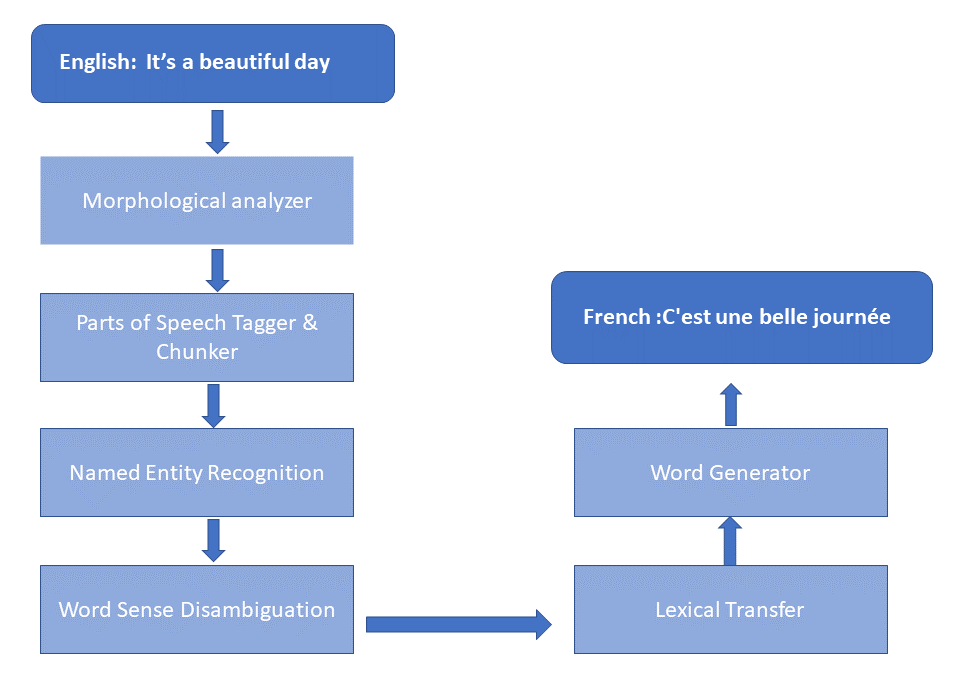


Le plus grand défaut de cette méthode est à la fois cette expertise requise pour définir des bonnes règles mais également le grand nombre de règles et d'exceptions qu'il faut intégrer.

Pour plus d'information sur les *rule-based systems*, la page [Wikipédia](https://en.wikipedia.org/wiki/Rule-based_machine_translation) explique bien le fonctionnement.

### Approche statistique pour la *machine translation*

Dans l'un des papiers fondateurs [ A Statistical Approach to Machine Translation](https://dl.acm.org/doi/10.5555/92858.92860) ,1990, les auteurs définissent cette approche de la manière suivante: 

> "*Given a sentence T in the target language, we seek the sentence S from which the translator produced T. We know that our chance of error is minimized by choosing that sentence S that is most probable given T. Thus, we wish to choose S so as to maximize Pr(S|T).*"

#### Un peu de théorie

En reprenant leur définition, on obtient la relation suivante: 

$Pr(S|T)=\frac{Pr(S)*Pr(T|S)}{Pr(T)}$

L' objet à produire étant S, et le dénominateur ne dépendant que de T, maximiser le terme de gauche revient à maximiser le numérateur du membre de droite.

Ainsi, un tel modèle doit fournir des méthodes capable de:
- Calculer $Pr(S)$, appelé par les auteurs "*the language model probability*" 
- Calculer $Pr(T|S)$, appelé par les auteurs "*the translation probability of T given S*" 
- Chercher parmis toutes les phrases S possibles celle qui maximise le produit des deux termes ci-dessus.

#### Place à un peu de pratique

Le modèle de langage est indépendant de la langue de traduction et peut être calculé de plusieurs façon différentes. La méthode la plus simple est un modèle **n-gram** dont le plus simple est le **unigram**. De cette façon, la probabilité d'un mot ne dépend que de la probabilité de ce mot dans le document tout entier. 

On va construire ici un modèle bi-grams en anglais à partir d'une base de donnée un peu plus grosse.

In [5]:
import nltk
nltk.download('reuters')
nltk.download('punkt')

[nltk_data] Downloading package reuters to /root/nltk_data...
[nltk_data]   Package reuters is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

Reuters corpus est un ensemble de plus de 10 000 documents soit 1.3M de mots.

In [6]:
from nltk.corpus import reuters
from nltk import bigrams
from collections import Counter, defaultdict

model = defaultdict(lambda: defaultdict(lambda: 0))

# Comptage du nombre de co-occurence  
for sentence in reuters.sents():
    for w1, w2 in bigrams(sentence, pad_right=True, pad_left=True):
        model[(w1)][w2] += 1
 
# Let's transform the counts to probabilities
for w1 in model:
    total_count = float(sum(model[w1].values()))
    for w2 in model[w1]:
        model[w1][w2] /= total_count

De cette façon on obtient un modèle qui peut fournir la probabilité d'une sequence, ici de taille deux, mais qui peut également prédire le mot suivant en lui fournissant les n-1 mots précédents, ici n=2.

In [26]:
dict(model['machine'])

{',': 0.06666666666666667,
 '-': 0.4,
 'business': 0.06666666666666667,
 'introduced': 0.06666666666666667,
 'tool': 0.13333333333333333,
 'tools': 0.2,
 'vision': 0.06666666666666667}

In [27]:
model['artificial']['intelligence']

0.1111111111111111

Il convient ensuite d'établir la table des probabilités de traduction d'un mot anglais en français. 

In [39]:
# Largement inspiré de https://github.com/sayarghoshroy/Statistical-Machine-Translation

# Calcul de t[('EN_word', 'FR_word')] = translation probability of EN_Word given FR_word
# Ce calcul se base sur la même hypothèse que le modèle IBM 1 à savoir que les probabilités des alignements sont uniformes

t = {}
uniform = 1 / (en_vocab * fr_vocab) #Probabilité uniforme
n_iters = 0
max_iters = 25
has_converged = False

while n_iters < max_iters and has_converged == False:
    has_converged = True
    max_change = -1

    n_iters += 1
    count = {}
    total = {}
    for index in range(train_size):
        s_total = {}
        for en_word in tokenized_stores['en_train'][index]:
            s_total[en_word] = 0
            for fr_word in tokenized_stores['fr_train'][index]:
                if (en_word, fr_word) not in t:
                    t[(en_word, fr_word)] = uniform
                s_total[en_word] += t[(en_word, fr_word)]

        for en_word in tokenized_stores['en_train'][index]:
            for fr_word in tokenized_stores['fr_train'][index]:
                if (en_word, fr_word) not in count:
                    count[(en_word, fr_word)] = 0
                count[(en_word, fr_word)] += (t[(en_word, fr_word)] / s_total[en_word])

                if fr_word not in total:
                    total[fr_word] = 0
                total[fr_word] += (t[(en_word, fr_word)] / s_total[en_word])

    # estimating the probabilities
    updated = {}
    # train for all valid word pairs s.t count(en_word, fr_word) > 0
    for index in range(train_size):
        for fr_word in tokenized_stores['fr_train'][index]:
            for en_word in tokenized_stores['en_train'][index]:
                if (en_word, fr_word) in updated:
                    continue
                updated[(en_word, fr_word)] = 1
                if abs(t[(en_word, fr_word)] - count[(en_word, fr_word)] / total[fr_word]) > 0.01:
                    has_converged = False
                    max_change = max(max_change, abs(t[(en_word, fr_word)] - count[(en_word, fr_word)] / total[fr_word]))
                t[(en_word, fr_word)] = count[(en_word, fr_word)] / total[fr_word]

    print("Iteration " + str(n_iters) + " Completed, Maximum Change: " + str(max_change))

Iteration 1 Completed, Maximum Change: 0.3333332642014897
Iteration 2 Completed, Maximum Change: 0.45514889629919497
Iteration 3 Completed, Maximum Change: 0.26451346126877456
Iteration 4 Completed, Maximum Change: 0.14997912825147608
Iteration 5 Completed, Maximum Change: 0.09517251182720032
Iteration 6 Completed, Maximum Change: 0.07336024359017601
Iteration 7 Completed, Maximum Change: 0.05782685512822322
Iteration 8 Completed, Maximum Change: 0.05041446236844857
Iteration 9 Completed, Maximum Change: 0.044482480780161454
Iteration 10 Completed, Maximum Change: 0.04279432638335773
Iteration 11 Completed, Maximum Change: 0.039936088961842586
Iteration 12 Completed, Maximum Change: 0.03522196512699982
Iteration 13 Completed, Maximum Change: 0.042351711107977925
Iteration 14 Completed, Maximum Change: 0.044244657540006144
Iteration 15 Completed, Maximum Change: 0.02659805402009144
Iteration 16 Completed, Maximum Change: 0.022287321495194162
Iteration 17 Completed, Maximum Change: 0.019

In [40]:
limit = 20
for element in sorted(t.items(), key = lambda k:(k[1], k[0]), reverse = True):
  print(element)
  limit -= 1
  if limit <= 0:
    break

(('meditating', 'mediter'), 0.9999999132391633)
(('escaping', 'echapper'), 0.9999767828250745)
(('undressing', 'deshabiller'), 0.9999767810032121)
(('.', '.'), 0.9999448483679816)
(('volunteering', 'benevolat'), 0.9997022219555491)
(('angry', 'enerve'), 0.9996258194477411)
(('deaf', 'sourde'), 0.9996184003410677)
(('concentrating', 'concentration'), 0.9994219100062821)
(('careless', 'negligent'), 0.9993853039923335)
(('patient', 'patiente'), 0.9991982712819356)
(('ruthless', 'pitie'), 0.9991092751278197)
(('now', 'desormais'), 0.9989745613200435)
(('invincible', 'invincible'), 0.9988946189221374)
(('upset', 'contrariee'), 0.9988404610028383)
(('open', 'ouverte'), 0.9979411523564075)
(('fasting', 'diete'), 0.9978160450998601)
(('generous', 'genereux'), 0.9977651228280315)
(('french', 'francais'), 0.9966452358057656)
(('patient', 'patient'), 0.9966161026417646)
(('my', 'mon'), 0.9962887347679686)


On a ainsi obtenu les différentes traductions possibles pour un mot donné avec leur probabilité.

On pourrait maintenant passer à une traduction naïve mot à mot. Cependant, cela ne fonctionnerait que très mal car il faut prendre en compte plusieurs autres points que la traduction brute des mots.

In [32]:
words = comtrans.words("alignment-en-fr.txt")

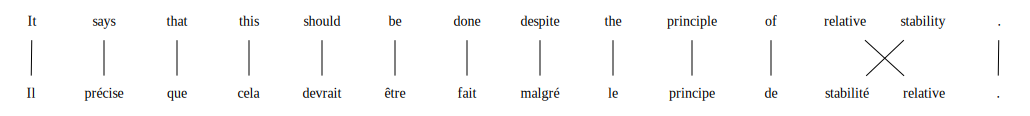

In [134]:
als = comtrans.aligned_sents("alignment-en-fr.txt")
als[13]

Le premier point que l'on peut observer sur l'image ci-dessus est que la position d'un mot dans une phrase en anglais n'est pas la même que la position d'un mot dans une phrase en français. Cela pourrait être résolu en réalisant toutes les permutations possibles pour une phrase traduite et évaluer chacune des traductions avec une fonction score. 


In [143]:
pair = random.choice(p)
en_token=word_tokenize(pair[0])
fr_token=word_tokenize(pair[1])
print(en_token)
print(fr_token)

['we', 're', 'ready', 'for', 'this', '.']
['nous', 'y', 'sommes', 'pretes', '.']


In [158]:
def find_translation(en_token):
    for element in sorted_t:
        if element[0][0].lower() == en_token:
            return element[0][1]
    return ""

s=''
for word in en_token:
  fr_word=find_translation(word)
  s+=' ' + fr_word
  print (word,'/',fr_word )

"""
#Pour tester toutes les permutations d'une traduction:

from itertools import permutation

def score(traduction):
  #Compléter avec une fonction permettant d'évaluer la qualité d'une traduction
  return(score)

perm = permutations(translated_words) #translated_words est la liste des mots traduits
best_trad = translated_words
best_s = -1

for trad in perm:
    s = score(trad)
    if s > best_s:
        best_s = s
        best_trad = trad

"""

print('')
print("> Phrase à traduire: ", ' '.join((en_token)))
print("> Phrase de référence: ", ' '.join(fr_token))
print("> Traduction: ", s)

we / nous
re / etes
ready / prete
for / pour
this / cet
. / .

> Phrase à traduire:  we re ready for this .
> Phrase de référence:  nous y sommes pretes .
> Traduction:   nous etes prete pour cet .


On observe de mauvais résultats avec cette méthode. Ici nous n'avons même pas besoin de permuter car les phrases sont assez basiques et pourtant les traductions restent médiocres.

Il y a plusieurs raisons à cela:
- La première est que nous considérons les mots lors de la traduction sans leur contexte. Un bi-grams permettrait déjà d'améliorer un peu cela. Ainsi, **re** pourrait être convenablement traduit en **sommes** car le mot précédent est **we** et non **you**.

- Une autre raison est qu'à chaque fois on traduit un mot anglais en un mot français. Cependant, à un mot anglais n'est pas toujours associé un mot français. Il peut y avoir plusieurs ou aucun mot correspondant. Ce nombre de mots nécessaire pour en traduire un autre est appelé *fertility*. 

- Il pourrait y avoir évidemment d'autres raisons, tels que la taille du dataset d'entrainement, le nombre d'itération lors de l'entrainement ...

Les deux premiers points sont extrêmement importants et des questions assez difficile à résoudre. Le premier point sera en parti résolu par l'utilisation de RNN afin d'introduire une notion de contexte lors de la traduction par les *decoder*. Il faudra attendre un peu plus longtemps pour voir un réel travail sur ce que l'on appelle l'alignement avec l'apparition des premiers modèles attentionnels (article [ici](https://arxiv.org/pdf/1409.0473.pdf)).

Pour déterminer ce paramètre de *fertility*, on utilise le principe d'**alignement**. Comme son nom l'indique, on va chercher quel(s) mot(s) dans la phrase en français s'aligne avec le mot initial en anglais. On cherche ainsi à obtenir des cartes d'alignements. 

La figure ci-dessous constitue une première visualtion d'alignement.

In [33]:
als = comtrans.aligned_sents("alignment-en-fr.txt")
print(" ".join(als[2].words))
print(" ".join(als[2].mots))
print(als[2].alignment)

You have requested a debate on this subject in the course of the next few days , during this part-session .
Vous avez souhaité un débat à ce sujet dans les prochains jours , au cours de cette période de session .
0-0 0-1 1-1 2-2 3-3 4-4 5-5 6-6 7-7 8-8 9-9 10-10 13-10 14-10 15-11 16-12 17-13 17-14 18-16 19-17 19-18 19-19 20-20


Voici une autre déjà plus lisble.

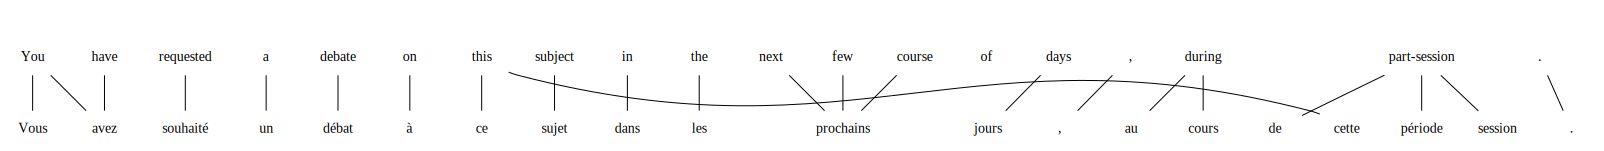

In [121]:
nb_s=2
als[nb_s] #Pour voir d'autre exemples d'alignement, il suffit de changer nb_s.

Et enfin, celle qui est la plus couramment utilisée, notamment en neural machine translation, est la matrice d'alignement:

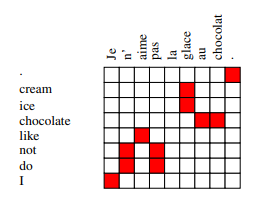

Un alignement mot à mot entre une phrase et sa traduction consiste à extraire des relations d’appariement entre les mots de la phrase source et les mots de sa traduction. Prédire automatiquement ces relations de traduction est une tâche qui a de nombreuses applications, par exemple, en recherche d’information multilingue ([Rogati et Yang, 2003](https://link.springer.com/chapter/10.1007/978-3-540-30222-3_12)), en aide à la traduction ou en extraction de lexiques bilingues ([Fung, 2000](https://link.springer.com/chapter/10.1007/978-94-017-2535-4_11)).

Initialement il existe deux méthodes différentes:

- La méthode IBM
- Une méthode basée sur les modèles de Markov cachés

[Voici](https://www.atala.org/content/mod%C3%A8les-discriminants-pour-l%E2%80%99alignement-mot-%C3%A0-mot) un article détaillant les différentes méthodes d'alignements ainsi que la modélisation mathématique qui va avec. 

Une fois ces alignements définis il est facile de calculer les probabilités associées à chaque valeur de fertilité pour chaque mot.

Dans l'exemple ci-dessous (tiré de l'article dont le lien est donné en début de section sur les approches statistiques), on observe ainsi que le mot français le plus probable pour la traduction de **NOT** est **PAS**. On remarque surtout qu'il est beaucoup plus probable que **NOT** soit traduit par deux mots en français avec une probabilité de $0.758$ pour une fertilité de $2$.

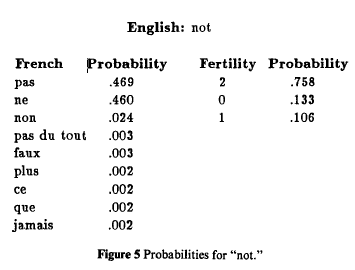

Avec tout cela, on dispose des outils pour calculer le numérateur et donc itérer sur les différentes traductions possibles et ainsi obtenir la meilleure.

Il y a de nombreuses limites à cette approche statistique. L'une d'elle est la quantité de donnée nécessaire. Par ailleurs, comme on a pu le voir dans cette partie, une telle approche nécessite de nombreux "modules" pour avoir une *pipeline* complète. Or, il faut un tuning de chacun des *modules* assez fin, ce qui peut être assez long et laborieux. 

Malgré tout, ce n'est qu'il y a quelques années alors que le *deep learning* est déjà en train de s'installer partout, que les approches statistiques commencent à être battues.

## De la nécessité d'une architecture Encoder/Decoder

En 2016, Google publie un article intitulé [Google’s Neural Machine Translation System: Bridging the Gap between Human and Machine Translation](https://arxiv.org/abs/1609.08144). Dans ce dernier, les auteurs présentent leur nouveau modèle de traduction utilisé pour remplacer l'approche anciennement classique du "*phrase-based statistical machine translation systems*".

Pourquoi un tel changement dans la méthodologie employée?

En 2016  avec un article très important en *Neural machine translation* ([Neural machine translation by jointly learning to align and translate](https://arxiv.org/abs/1409.0473)), les auteurs expliquent bien ce changement de méthode:

> "*Unlike the traditional phrase-based translation system which consists of many small sub-components that are tuned separately, neural machine translation attempts to build and train a single, large neural network that reads a sentence and outputs a correct translation*". 

Ainsi, comme on l'a vu dans la section précédente, tuner toute la *pipeline* peut être long, et les réseaux de neurones permettent de condenser toute cette *pipeline* en un seul "module".

Les réseaux de neurones semblent donc faciliter la vie des ingénieurs. Cependant, ce n'est pas la solution miracle. Il faudra se souvenir du problème rencontré et à priori non résolu par un simple réseau de neurone: le **contexte**. De plus, comme on l'a mentionné dans la section de rappel, il va falloir trouver une réprésentation adaptée pour les phrases/mots afin de conserver un maximum de sens celle-ci.

Avec l'apparition des réseaux récurrents connus pour leur capacité à **retenir** l'information, il semble logique de vouloir tenter de l'appliquer au problème de la traduction qui nécessite une **mémoire** des mots/phrases précédentes.

### Encoder/Decoder c'est quoi ?

Il s'agit d'un type d'architecture constitué de deux réseaux de neurones en série, l'*encoder* et le *decoder*.

L'*encoder* va encoder l'entrée, en général une séquence de mots, dans un vecteur appelé le vecteur de contexte ou *context vector* de taille fixée. Celui-ci est supposément un condensé de la séquence d'entrée contenant l'information nécessaire pour la suite.

Ce dernier est fourni en entrée du *decoder* qui va s'occuper de décoder ce vecteur et fournir en sortie la séquence voulue, en général la suite d'une phrase ou bien comme ici une traduction.

Ce type d'approche est connu sous le nom **seq2seq** pour *sequence to sequence*. Ils font en général appel à des RNN, et plus particulièrement des LSTM et des GRU pour contrer le problème du gradient évanescent ou *vanishing gradient*.

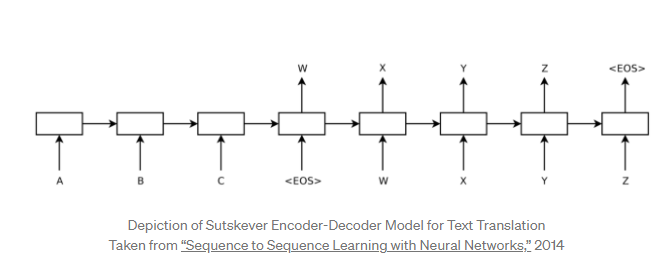

### Approche par réseau récurrent

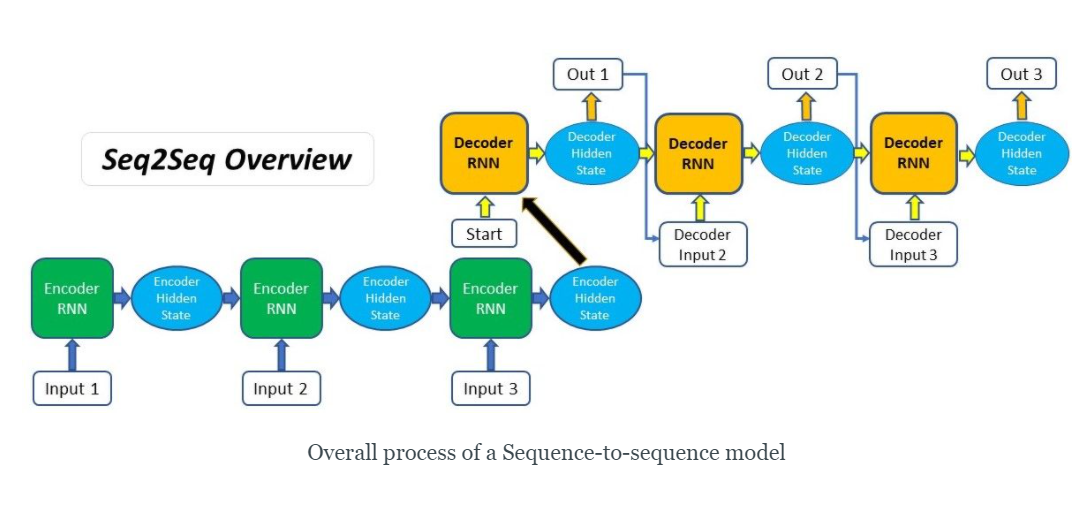

Avec cette approche, l'*encoder* reçoit à chaque pas de temps un token d'entrée ainsi que l'*hidden state* produit lors du pas de temps précédent. Un vecteur caché, formant l'*hidden state* va alors être produit. Le vecteur renvoyé au dernier pas de temps formera le *context vector*, *hidden state* initial du *decoder*.

Le decoder lui va recevoir en entrée également un vecteur représentant l'*hidden state* du pas de temps précédent. En sortie, il va produire un token et un *hidden state* représentant ce qu'il reste à faire. On répètera cette démarche jusqu'à ce que le token $<EOS>$ soit produit, token marquant la fin de la phrase.

Pour l'essentiel du code qui suit, on va suivre l'excellent tutoriel de [pytorch](https://pytorch.org/tutorials/intermediate/seq2seq_translation_tutorial.html) à nouveau.

In [30]:
# STEP 1
def indexesFromSentence(lang, sentence):
    return [lang.word2index[word] for word in sentence.split(' ')]

# STEP 2
def tensorFromSentence(lang, sentence):
    indexes = indexesFromSentence(lang, sentence)
    indexes.append(End_sentence_token)
    return torch.tensor(indexes, dtype=torch.long, device=device).view(-1, 1)

# Performing the two steps of vectorization on a pair of english/french sequences
def tensorsFromPair(pair):
    input_tensor = tensorFromSentence(input_lang, pair[0])
    target_tensor = tensorFromSentence(output_lang, pair[1])
    return (input_tensor, target_tensor)

hidden_size=256

####L'*Encoder*

On va donc commencer par l'*encoder* dont voici un schéma de fonctionnement à chaque pas de temps:

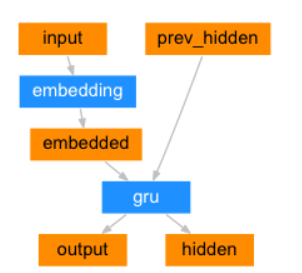

L'entrée est un mot donc comme nous l'avons vu au début du notebook, il convient d'appliquer un *embedding* dessus afin qu'il soit compréhensible par le réseau. 
On passe également en entrée le précédent *hidden state*. Ici il s'agira d'ailleurs d'un LSTM et non d'un GRU comme l'indique le schéma.

In [25]:
class Encoder(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(Encoder, self).__init__()
        
        self.hidden_size = hidden_size
        self.embedding = nn.Embedding(input_size, hidden_size)
        self.lstm = nn.LSTM(hidden_size, hidden_size)
        
        
    def forward(self, input, hidden):
        
        embedded = self.embedding(input).view(1, 1, -1)
        output = embedded
        output, hidden = self.lstm(output, hidden)
        return output, hidden

####Le *Decoder*

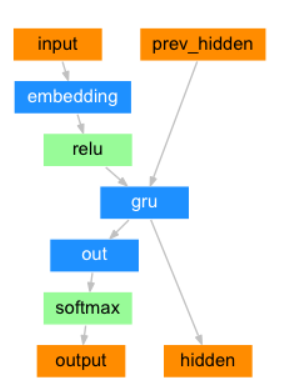

Comme on l'a déjà vu, le *decoder* prend en entrée le précédent état caché mais aussi un token d'entrée, correspondant au token précédemment prédis. Il existe néanmoins une variante permettant d'obtenir de meilleur résultat: cette méthode est connue sous le nom de *teacher forcing*.

Avec cette méthode, on donne en entrée le token précédent qui était attendu et non pas celui produit par le *decoder* à l'étape précédente. Il s'agit d'une méthode d'entrainement permettant de réduire le temps de calcul tout en maintenant de très bonne performance.

Cette méthode peut cependant souffrir d'un problème de "créativité" et sera éventuellement moins performante pour traduire des formes jamais vues.

In [24]:
class Decoder(nn.Module):
    def __init__(self, hidden_size, output_size):
        super(Decoder, self).__init__()
        
        self.hidden_size = hidden_size
        self.embedding = nn.Embedding(output_size, hidden_size)
        self.lstm = nn.LSTM(hidden_size, hidden_size)
        self.out = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        
        output = self.embedding(input).view(1, 1, -1)
        output = F.relu(output)
        output, hidden = self.lstm(output, hidden)
        output = self.softmax(self.out(output[0]))
        
        return output, hidden

####Entraînement

Dans cette section, on va s'occuper de l'entrainement mais celui-ci prenant beaucoup de temps (à lire et surtout à exécuter), il peut être recommandé de directement passé au résultat. Pour avoir des détails sur cette étape, je vous conseille de directement aller voir le tutoriel pytorch (lien juste avant la section *Encoder*).

In [31]:
#Extrait du notebook 4 de NLP

def train(input_tensor, target_tensor, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion, max_length=max_length):
    
    #initialize hidden and cell state of the encoder lstm randomly
    encoder_hidden = torch.randn(1, 1, hidden_size).to(device)
    encoder_cell = torch.randn(1, 1, hidden_size).to(device)

    #zero out the gradients
    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()
    
    #Get length of input and target sequences
    input_length = input_tensor.size(0)
    target_length = target_tensor.size(0)

    loss = 0
    
    ## ENCODER
    #initialize the output of the encoder to zero
    encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)
    # print(encoder_outputs.type())
    #We pass each input token to the encoder. At each step, we retrive the output and the hidden/cell states,
    #forming the context vector. The context vector is fed back to the encoder for the next step.
    for ei in range(input_length):
        encoder_output, (encoder_hidden,encoder_cell) = encoder(input_tensor[ei], (encoder_hidden,encoder_cell))
        encoder_outputs[ei] = encoder_output[0, 0]

    ## DECODER
    #For the decoder, the input is initialized with a Start of Sequence token
    decoder_input = torch.tensor([[Start_sentence_token]], device=device)

    #The decoder states are initialized by passing the context vector from the encoder
    decoder_hidden = encoder_hidden
    decoder_cell = encoder_cell
    
    #We pass each target token to the decoder. We keep the hidden and cell states, that we will feed back to the
    #decoder for the next step. However, the outputs are discarded, and the next input of the decoder is the target
    #output (see teacher forcing above)
    for di in range(target_length):
        decoder_output, (decoder_hidden,decoder_cell) = decoder(decoder_input, (decoder_hidden,decoder_cell))
        loss += criterion(decoder_output, target_tensor[di])
        decoder_input = target_tensor[di]  # Teacher forcing

    #Backward prop
    loss.backward()
    encoder_optimizer.step()
    decoder_optimizer.step()

    #Return loss
    return loss.item() / target_length

In [32]:
import matplotlib.pyplot as plt
plt.switch_backend('agg')
import matplotlib.ticker as ticker
import numpy as np


def showPlot(points):
    plt.figure()
    fig, ax = plt.subplots()
    loc = ticker.MultipleLocator(base=0.2)
    ax.yaxis.set_major_locator(loc)
    plt.plot(points)

In [33]:
def trainIters(encoder, decoder, n_iters, print_every=1000, plot_every=100, learning_rate=0.01):
    
    plot_losses = [] #Will hold all losses for plotting
    print_loss_total = 0  # Reset every print_every
    plot_loss_total = 0  # Reset every plot_every

    #Setup optimizers
    encoder_optimizer = optim.SGD(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.SGD(decoder.parameters(), lr=learning_rate)
    
    #Prepare n_iter training data to run n-iter steps
    training_pairs = [tensorsFromPair(random.choice(pairs)) for i in range(n_iters)]
    
    criterion = nn.NLLLoss()

    
    for iter in range(1, n_iters + 1):
        training_pair = training_pairs[iter - 1]
        
        # Retrieve the next tensors for input and target
        input_tensor = training_pair[0]
        target_tensor = training_pair[1]
        
        #Run one step of training
        loss = train(input_tensor, target_tensor, encoder,decoder, encoder_optimizer, decoder_optimizer, criterion)
        print_loss_total += loss
        plot_loss_total += loss

        #Every few steps, we print the current status of training. We also store the loss for plotting
        if iter % print_every == 0:
            print_loss_avg = print_loss_total / print_every
            print_loss_total = 0
            print('(iteration %d %d%%) loss = %.4f' % (iter, iter / n_iters * 100, print_loss_avg))

        if iter % plot_every == 0:
            plot_loss_avg = plot_loss_total / plot_every
            plot_losses.append(plot_loss_avg)
            plot_loss_total = 0

    #Plot learning curve at the end
    showPlot(plot_losses)


In [34]:
encoder = Encoder(input_lang.n_words, hidden_size).to(device)
decoder = Decoder(hidden_size, output_lang.n_words).to(device)

print(next(encoder.parameters()).device)
print(next(decoder.parameters()).device)

trainIters(encoder, decoder, 75000, print_every=1000,plot_every=100)

cuda:0
cuda:0
(iteration 1000 1%) loss = 4.3359
(iteration 2000 2%) loss = 3.6349
(iteration 3000 4%) loss = 3.3702
(iteration 4000 5%) loss = 3.1993
(iteration 5000 6%) loss = 3.0269
(iteration 6000 8%) loss = 2.9529
(iteration 7000 9%) loss = 2.8280
(iteration 8000 10%) loss = 2.7427
(iteration 9000 12%) loss = 2.6324
(iteration 10000 13%) loss = 2.5457
(iteration 11000 14%) loss = 2.4745
(iteration 12000 16%) loss = 2.4562
(iteration 13000 17%) loss = 2.3544
(iteration 14000 18%) loss = 2.2529
(iteration 15000 20%) loss = 2.2532
(iteration 16000 21%) loss = 2.1574
(iteration 17000 22%) loss = 2.0606
(iteration 18000 24%) loss = 2.0948
(iteration 19000 25%) loss = 2.0727
(iteration 20000 26%) loss = 2.0096
(iteration 21000 28%) loss = 1.9805
(iteration 22000 29%) loss = 1.9205
(iteration 23000 30%) loss = 1.9239
(iteration 24000 32%) loss = 1.8299
(iteration 25000 33%) loss = 1.8330
(iteration 26000 34%) loss = 1.7638
(iteration 27000 36%) loss = 1.7352
(iteration 28000 37%) loss = 1

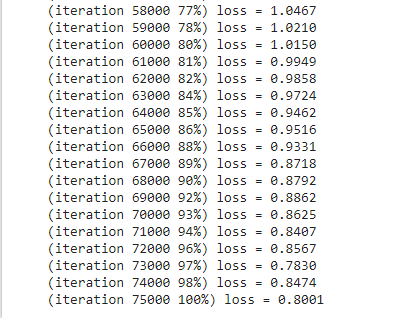

Extrait d'un résultat d'entraînement

In [35]:
def inference(encoder, decoder, sentence, max_length=max_length):
    
    with torch.no_grad(): #Freeze gradient
        
        input_tensor = tensorFromSentence(input_lang, sentence)
        input_length = input_tensor.size()[0]
        
        #Initialize the encoder hidden states
        encoder_hidden = torch.randn(1, 1, hidden_size).to(device)
        encoder_cell = torch.randn(1, 1, hidden_size).to(device)

        encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

        ##ENCODER
        for ei in range(input_length):
            encoder_output, (encoder_hidden,encoder_cell) = encoder(input_tensor[ei],
                                                     (encoder_hidden,encoder_cell))
            encoder_outputs[ei] += encoder_output[0, 0]

        #Initialize decoder input with a start of sentence token
        decoder_input = torch.tensor([[Start_sentence_token]], device=device) 

        #Feed the encoder context vectors to the decoder
        decoder_hidden = encoder_hidden
        decoder_cell=encoder_cell

        decoded_words = [] #Will hold the decoded sequence (translation)

        for di in range(max_length):
            decoder_output, (decoder_hidden,decoder_cell) = decoder(decoder_input, (decoder_hidden,decoder_cell))
            
            topv, topi = decoder_output.data.topk(1)
            if topi.item() == End_sentence_token:
                decoded_words.append('<EOS>')
                break #Stop if we predict an end of sentence token
            else:
                decoded_words.append(output_lang.index2word[topi.item()])

            decoder_input = topi.squeeze().detach() #Use the previously predicted token as the input for the next step

        return decoded_words

In [36]:
def evaluateRandomly(encoder, decoder, n=10):
    for i in range(n):
        pair = random.choice(pairs)
        print('>', pair[0])
        print('=', pair[1])
        output_words = inference(encoder, decoder, pair[0])
        output_sentence = ' '.join(output_words)
        print('<', output_sentence)
        print('')

#### Résultat d'entraînement

Voici les résultats obtenus après $75000$ itérations:

In [37]:
evaluateRandomly(encoder, decoder)

> i m not a violent person .
= je ne suis pas quelqu un de violent .
< je ne suis pas une personne plus . <EOS>

> i m looking forward to receiving your reply .
= j ai hate de recevoir ta reponse .
< j ai hate de tes problemes de problemes . <EOS>

> you re very attractive .
= vous etes tres attirants .
< vous etes fort attirante . <EOS>

> he is in the bathroom .
= il est dans la salle de bain .
< il est dans la salle de classe . <EOS>

> i m not patient .
= je ne suis pas patiente .
< je ne suis pas patiente . <EOS>

> we re an hour behind .
= nous avons une heure de retard .
< nous avons une faim de retard . <EOS>

> i m very upset .
= je suis fort contrarie .
< je suis tres contrariee . <EOS>

> i m no longer angry at you .
= je ne suis plus en colere apres vous .
< je ne suis plus en colere apres vous . <EOS>

> i m glad to see you .
= je suis heureux de te voir .
< je suis heureux de te voir . <EOS>

> i m your lawyer .
= je suis votre avocat .
< je suis votre avocat . <EOS>



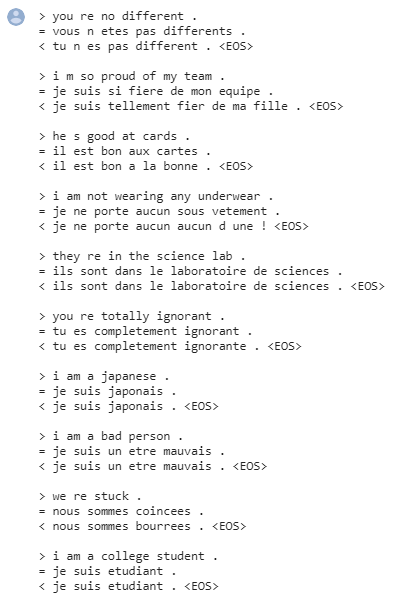

$75000$ itérations est évidemment insuffisant et un dataset de plus grande taille serait également préférable. Cependant, on observe tout de même de bon résultat pour un réseau non tuner entrainé pendant environ 30minutes.

Quelques sources d'améliorations sont quand-même notables:

- Ne pas utiliser le *teacher forcing* à chaque pas de temps. Une implémentation de cette étape est également fourni sur le tutoriel pytorch.

- La représentation, le contexte et l'alignement sont des concepts très importants comme nous l'avons déjà vu. Or, avec une telle architecture, toutes ces étapes reposent entièrement sur l'*encoder*. De plus, la taille du *context vector* étant fixée, un seul *context vector* aura du mal a représenté correctement les phrases longues. 

En réponse à ces problèmes, Bahdanau et al. propose en 2016 ([Neural machine translation by jointly learning to align and translate](https://arxiv.org/abs/1409.0473), ), une amélioration: **l'attention**.

###Méthode attentionnelle

Dans cette partie, nous allons voir ce qu'est l'attention et comment peut-on appliquer cela à notre modèle précédent.

####Qu'est-ce que l'attention ?

L'attention est communément appelé pour parler d'une faculté de l'esprit humain. Cette dernière nous permet de concentrer nos sens et nos facultés mentales sur une tâche ou un objet afin d'en capter un maximum d'information. 

Voici une définition donnée en 1890 par l'un des pères de la psychologie américaine Willian James: 



> "*Everyone knows what attention is. It is the
taking possession of the mind, in clear and
vivid form, of one out of what seem several
simultaneous possible objects or trains of
thought. Focalization, concentration of
consciousness are of its essence. It implies
withdrawal from some things in order to
deal effectively with others, and is a
condition which has a real opposite in the
confused, dazed, scatterbrain state*"


Il s'agit d'un processus psychologique essentiel, sans lequel notre cerveau ne serait pas capable de traiter toutes les informations de notre environnement si rapidement car ce dernier ne possède pas une mémoire de travail illimité. C'est d'ailleurs également le cas des ordinateurs/serveurs mais aussi des GPUs pour le *deep learning*.

Ainsi, ce mécanisme nous permet de sélectionner l'information que l'on juge importante pour la réalisation d'une tâche. 

Il existe de nombreux exemples de ce caractère sélectif de l'attention et notamment des vidéos assez impressionnantes:

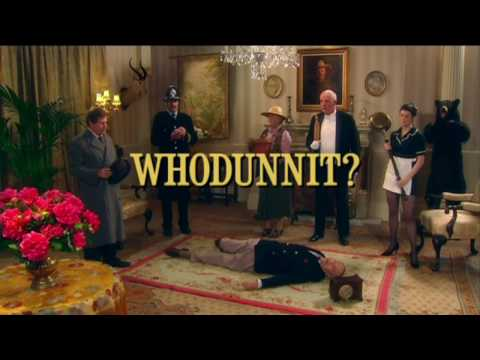

In [38]:
from IPython.display import YouTubeVideo
YouTubeVideo('ubNF9QNEQLA') #Ma préférée

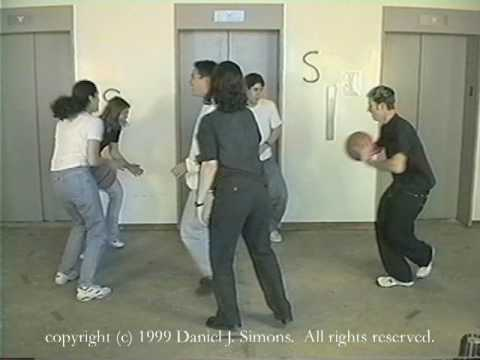

In [39]:
from IPython.display import YouTubeVideo
YouTubeVideo('vJG698U2Mvo') #Plus de 24M de vue

Voici les liens si la lecture ne fonctionne pas sur le notebook: [celle-ci](https://www.youtube.com/watch?v=vJG698U2Mvo) pour la plus connue ou bien [celle-là](https://www.youtube.com/watch?v=ubNF9QNEQLA) pour ma préférée.


####*Attention based neural machine translation*

Comme on l'a déjà mentionné dans la partie sur les RNN, la faiblesse de ces architectures et que toute la responsabilité de la capture du sens et contexte d'une phrase repose sur l'encoder. C'est cette faiblesse qu'essaye de résoudre Bahdanau dans son article:

>"*By letting the decoder have an attention mechanism, we relieve the
encoder from the burden of having to encode all information in the source sentence into a fixedlength
vector.*"

Cette nouveauté a grandement amélioré les performances des systèmes de traduction automatique. En effet, le mécanisme attentionnel permet au *decoder* de se concentrer sur les parties importantes de la phrase à traduire.

##### Comment ça fonctionne en pratique ?

Le principe de l'attention est en fait assez intuitive. En effet, au lieu de ne donner en entrée du *decoder* uniquement l'*hidden state* précédent, ce dernier recevra aussi tous ou bien une partie des *hidden states* de l'*encoder*. De cette façon, le *decoder* aura accès aux contextes de chaque mot de la phrase. Cela paraît assez clair qu'avec cela il devrait être plus facile de déterminer les relations entre les différents mots.

A partir de ça et de l'*hidden state* du decoder, un *alignment score* ou *alignment weight* ou *attention weight* va être calculer pour chaque *hidden state*. 

Enfin, tous les *hidden states* vont être multipliés par leur score respectif, fournissant ainsi une *alignement probability vector* pour chaque mot !  Ces derniers permettent de montrer ou le réseau porte son attention au vu du mot actuel à traduire.

En récupérant l'ensemble de ces vecteurs on peut obtenir une matrice d'alignement:

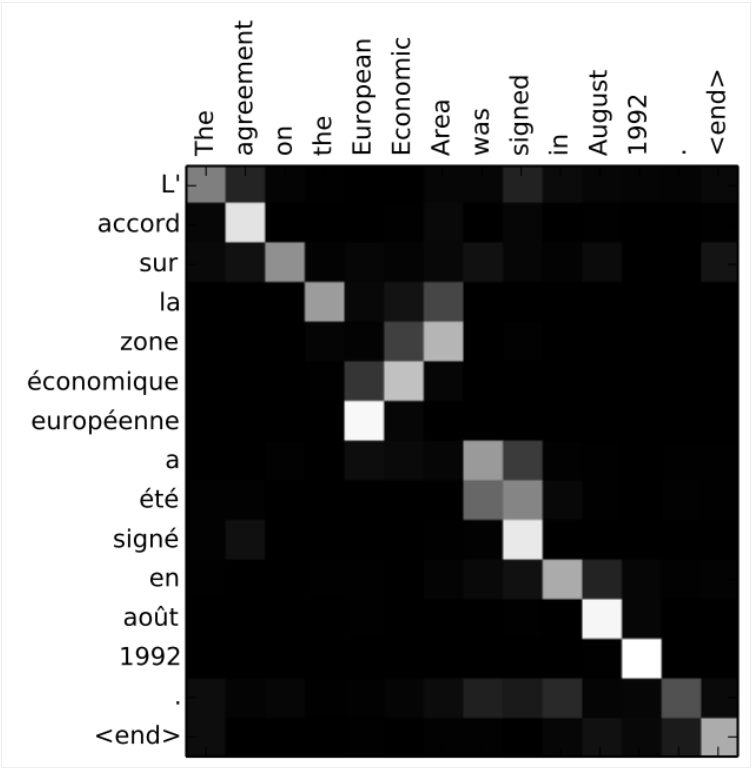

On voit sur cette exemple que pour traduire *European Economic area* le réseau a bien porté son attention sur *européenne* puis *economic* puis *zone* et a ainsi évité le piège de l'inversion des structures entre l'anglais et le français.

Un tel mécanisme a un avantage énorme: le réseau n'est plus complètement une boite noire. On est en effet maintenant capable de comprendre pourquoi un mot a été traduit de telle façon grâce à cette matrice. On est ainsi capable d'avoir un peu plus d'information sur ce qu'il se passe. 

Cette interpétabilité est une caractéristique essentielle de ce type de réseau. C'est un sujet de recherche très important aujourd'hui et qui bloque encore le développement des systèmes autonomes. Il semble en effet très compliqué de faire confiance à un système dont on ne peut expliquer les décisions.


Voici le nouveau schéma d'un *decoder* attentionnel très simple.

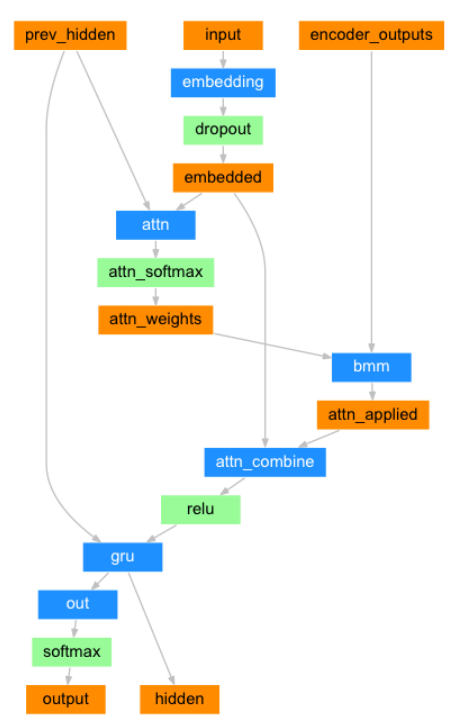

L'*encoder* restant inchangée on va fournir une implémentation uniquement du *decoder*. Encore une fois, celle-ci est tirée du tutoriel pytorch.

In [40]:
class AttnDecoder(nn.Module):
    def __init__(self, hidden_size, output_size, dropout_p=0.1, max_length=max_length):
        super(AttnDecoder, self).__init__()
        
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.dropout_p = dropout_p 
        self.max_length = max_length

        self.embedding = nn.Embedding(self.output_size, self.hidden_size)
        
        self.attn = nn.Linear(self.hidden_size * 2, self.max_length) #La couche pour calculer les poids attentionnels
        self.attn_combine = nn.Linear(self.hidden_size * 2, self.hidden_size) #Combinaison de mot d'entrée et du vecteur de contexte avec attention 
        self.dropout = nn.Dropout(self.dropout_p)
        
        self.lstm = nn.LSTM(self.hidden_size, self.hidden_size)
        self.out = nn.Linear(self.hidden_size, self.output_size)

    def forward(self, input, hidden, encoder_outputs):
        
        embedded = self.embedding(input).view(1, 1, -1)
        embedded = self.dropout(embedded)
        
       
        attn_weights = F.softmax(self.attn(torch.cat((embedded[0], hidden[0][0]), 1)), dim=1) #Calcul des poids attentionnels des context vectors
        attn_applied = torch.bmm(attn_weights.unsqueeze(0),encoder_outputs.unsqueeze(0))#On "pondère" chaque hidden state par son poids. 
        #Les zones auxquelles il faut faire attention auront ainsi des scores plus élevés.

        output = torch.cat((embedded[0], attn_applied[0]), 1)
        output = self.attn_combine(output).unsqueeze(0)
        output = F.relu(output)
        
        #Decoder classique
        output, hidden = self.lstm(output, hidden)
        output = F.log_softmax(self.out(output[0]), dim=1)
        
        return output, hidden, attn_weights #On retourne les poids attentionnels pour l'explicabilité.

#####Entraînement

Encore une fois, dans cette section, on va s'occuper de l'entrainement mais celui-ci prenant beaucoup de temps (à lire et surtout à exécuter), il peut être recommandé de directement passé au résultat. 

In [43]:
#Extrait du notebook 4 de NLP

def train_with_attention(input_tensor, target_tensor, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion, max_length=max_length):

    encoder_hidden = torch.randn(1, 1, hidden_size).to(device)
    encoder_cell = torch.randn(1, 1, hidden_size).to(device)

    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    input_length = input_tensor.size(0)
    target_length = target_tensor.size(0)

    encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

    loss = 0

    for ei in range(input_length):
        encoder_output, (encoder_hidden,encoder_cell) = encoder(input_tensor[ei], (encoder_hidden,encoder_cell))
        encoder_outputs[ei] = encoder_output[0, 0]

    decoder_input = torch.tensor([[Start_sentence_token]], device=device)

    decoder_hidden = encoder_hidden
    decoder_cell = encoder_cell
    
    # THE ONLY CHANGES OCCURS HERE, AS WE NEED TO ADD encoder_output AS AN INPUT AND attention AS AN OUTPUT
    for di in range(target_length):
        decoder_output, (decoder_hidden,decoder_cell), decoder_attention  = decoder(decoder_input, (decoder_hidden,decoder_cell), encoder_outputs)
        loss += criterion(decoder_output, target_tensor[di])
        decoder_input = target_tensor[di]  # Teacher forcing

    loss.backward()

    encoder_optimizer.step()
    decoder_optimizer.step()

    return loss.item() / target_length

#Iterations of training
def trainIters_with_attention(encoder, decoder, n_iters, print_every=1000, plot_every=100, learning_rate=0.01):
    plot_losses = []
    print_loss_total = 0
    plot_loss_total = 0 

    encoder_optimizer = optim.SGD(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.SGD(decoder.parameters(), lr=learning_rate)
    training_pairs = [tensorsFromPair(random.choice(pairs)) for i in range(n_iters)]
    criterion = nn.NLLLoss()

    for iter in range(1, n_iters + 1):
        training_pair = training_pairs[iter - 1]
        input_tensor = training_pair[0]
        target_tensor = training_pair[1]
        
        #THE ONLY CHANGE HAPPENS HERE, AS WE NEED TO CALL THE TRAIN_WITH_ATTENTION FUNCTION
        loss = train_with_attention(input_tensor, target_tensor, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion)
        print_loss_total += loss
        plot_loss_total += loss

        if iter % print_every == 0:
            print_loss_avg = print_loss_total / print_every
            print_loss_total = 0
            print('(iteration %d %d%%) loss = %.4f' % (iter, iter / n_iters * 100, print_loss_avg))

        if iter % plot_every == 0:
            plot_loss_avg = plot_loss_total / plot_every
            plot_losses.append(plot_loss_avg)
            plot_loss_total = 0

    showPlot(plot_losses)
  
#evaluation function
def inference_with_attention(encoder, decoder, sentence, max_length=max_length):
    with torch.no_grad():
        input_tensor = tensorFromSentence(input_lang, sentence)
        input_length = input_tensor.size()[0]
        encoder_hidden = torch.randn(1, 1, hidden_size).to(device)
        encoder_cell = torch.randn(1, 1, hidden_size).to(device)

        encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

        for ei in range(input_length):
            encoder_output, (encoder_hidden,encoder_cell) = encoder(input_tensor[ei],
                                                     (encoder_hidden,encoder_cell))
            encoder_outputs[ei] += encoder_output[0, 0]

        decoder_input = torch.tensor([[Start_sentence_token]], device=device)  # SOS

        decoder_hidden = encoder_hidden
        decoder_cell = encoder_cell

        decoded_words = []
        decoder_attentions = torch.zeros(max_length, max_length)

        # ONLY CHANGE IS HERE
        for di in range(max_length):
            decoder_output, (decoder_hidden,decoder_cell), decoder_attention = decoder(
                decoder_input, (decoder_hidden,decoder_cell), encoder_outputs)
            decoder_attentions[di] = decoder_attention.data
            topv, topi = decoder_output.data.topk(1)
            if topi.item() == End_sentence_token:
                decoded_words.append('<EOS>')
                break
            else:
                decoded_words.append(output_lang.index2word[topi.item()])

            decoder_input = topi.squeeze().detach()

        return decoded_words, decoder_attentions[:di + 1]

#evaluate several sentences picked randomly    
def evaluateRandomly_with_attention(encoder, decoder, n=10):
    for i in range(n):
        pair = random.choice(pairs)
        print('>', pair[0])
        print('=', pair[1])
        output_words, attentions = inference_with_attention(encoder, decoder, pair[0])
        output_sentence = ' '.join(output_words)
        print('<', output_sentence)
        print('')

In [45]:
encoder_for_attn = Encoder(input_lang.n_words, hidden_size).to(device)
attn_decoder = AttnDecoder(hidden_size, output_lang.n_words, dropout_p=0.1).to(device)


trainIters_with_attention(encoder_for_attn, attn_decoder, 50000, print_every=500,plot_every=50)

(iteration 500 1%) loss = 4.9022
(iteration 1000 2%) loss = 3.9232
(iteration 1500 3%) loss = 3.6245
(iteration 2000 4%) loss = 3.3912
(iteration 2500 5%) loss = 3.3412
(iteration 3000 6%) loss = 3.2084
(iteration 3500 7%) loss = 3.1402
(iteration 4000 8%) loss = 3.1365
(iteration 4500 9%) loss = 2.9713
(iteration 5000 10%) loss = 2.9241
(iteration 5500 11%) loss = 2.8951
(iteration 6000 12%) loss = 2.8764
(iteration 6500 13%) loss = 2.7271
(iteration 7000 14%) loss = 2.6970
(iteration 7500 15%) loss = 2.7003
(iteration 8000 16%) loss = 2.6242
(iteration 8500 17%) loss = 2.5421
(iteration 9000 18%) loss = 2.4472
(iteration 9500 19%) loss = 2.4345
(iteration 10000 20%) loss = 2.4736
(iteration 10500 21%) loss = 2.4298
(iteration 11000 22%) loss = 2.4191
(iteration 11500 23%) loss = 2.4023
(iteration 12000 24%) loss = 2.3112
(iteration 12500 25%) loss = 2.2704
(iteration 13000 26%) loss = 2.2513
(iteration 13500 27%) loss = 2.2216
(iteration 14000 28%) loss = 2.2134
(iteration 14500 28%)

##### Résultat d'entraînement

Voici les résultats obtenus après $50000$ itérations:

In [46]:
evaluateRandomly_with_attention(encoder_for_attn, attn_decoder)

> you re totally ignorant .
= vous etes completement ignorante .
< tu es completement completement . <EOS>

> i m learning to play the guitar now .
= j apprends a jouer de la guitare maintenant .
< j en ai marre de faire la queue . <EOS>

> i am an english teacher .
= je suis professeur d anglais .
< je suis un professeur de l anglais . <EOS>

> he is taller than his father .
= il est plus grand que son pere .
< il est plus grand que son pere . <EOS>

> i m proud to be your father .
= je suis fier d etre ton pere .
< je suis ravi de tes rencontrer . <EOS>

> you re not even paying attention .
= vous ne pretez meme pas attention .
< tu ne fais pas attention a tout . <EOS>

> you re disappointed aren t you ?
= vous etes decus n est ce pas ?
< vous etes curieux n est ce pas ? <EOS>

> they re hard to find .
= ils sont durs a trouver .
< elles sont a l habitude de faire . <EOS>

> i m glad that makes you happy .
= je suis content que ca te rende heureux .
< je suis content que ca vous rend

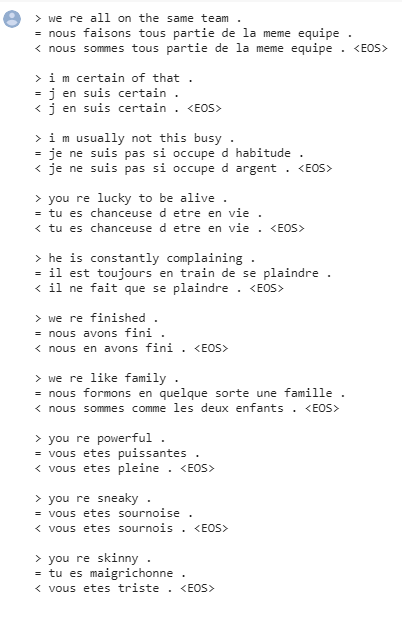

Les résultats sont très peu satisfaisants. Cela est peut être du à nouveau à la taille des datasets, ou au faible nombre d'itération. 

Il s'agit de plus d'un premier modèle, du tuning des hyperparamètres est évidemment requis! Pour se convaincre, voici les résultats de Bahdanau avec des réseaux attentionnels:

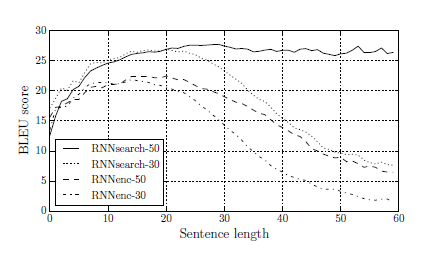

Sur cette figure, les modèles attentionnels sont nommés *RNNsearch*. Le nombre après le nom de l'algorithme correspond à la longueur maximale des phrases utilisées pour l'entrainement donc jusqu'à 50 mots pour le modèle qui performe bien *RNNsearch-50*.

On observe une performance bien meilleure par rapport au modèle de RNN non attentionel.

Par ailleurs, on avait parlé d'un autre problème des RNN pures qui était que la performance de ceux-ci diminuait avec la longueur des phrases.

Avec un decoder attentionnel, ce problème semble résolu d'après ces courbes

####Les différentes formes d'attentions

Nous en arrivons enfin à l'article initiale [Effective Approaches to Attention-based Neural Machine Translation](https://arxiv.org/abs/1508.04025), Luong.

Cet article reprend l'approche attentionnel de Bahdanau mais va y apporter pas mal de modifications. 

En effet, la façon de calculer l'*alignement score* ou poids attentionel diffère chez les deux auteurs. Or ce score est l'essence même du mécanisme attentionel car c'est ce dernier qui va indiquer quels sont les parties importantes de la phrase.

Bahdanau a une approche dite additive, c'est à dire basée sur la concaténation des *hidden states* de l'*encoder* avec l'*hidden state* du *decoder* à l'étape précédente, contre multiplicative pour Luong avec quatres propositions de fonctions:

- "Location": Basée uniquement sur le *hidden state* du *decoder*

- "Dot" : Effectue le *dot product* des *hidden states* de l'*encoder* avec l'*hidden state* du *decoder*

- "General": "Dot" score multiplié par une couche *Linear*

- "Concat": Similaire à Bahdanau, excepté que la concaténation est faite avant le produit par une couche *Linear*

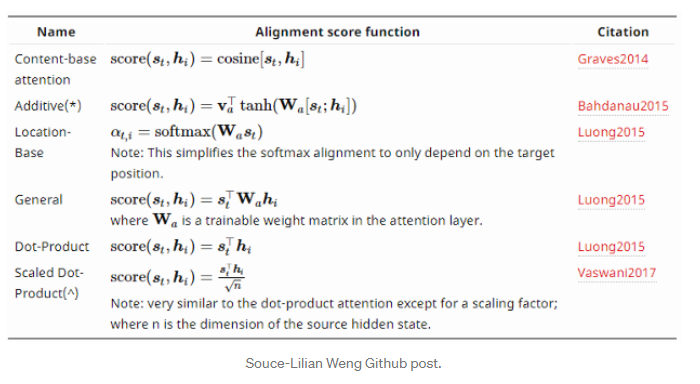

Par ailleurs, Luong définit deux types de mécanisme attentionnel:

- Une attention globale, celle utilisée par Bahdanau

- Une attention locale

Contrairement à l'attention globale, le mécanisme locale prédit d'abord une position d'alignement unique $p_{t}$ pour le mot à traduire et ainsi ne regarde les *hidden states* que dans une fenêtre autour du mot pour le calcul des poids ainsi que celui du *context vector*. 

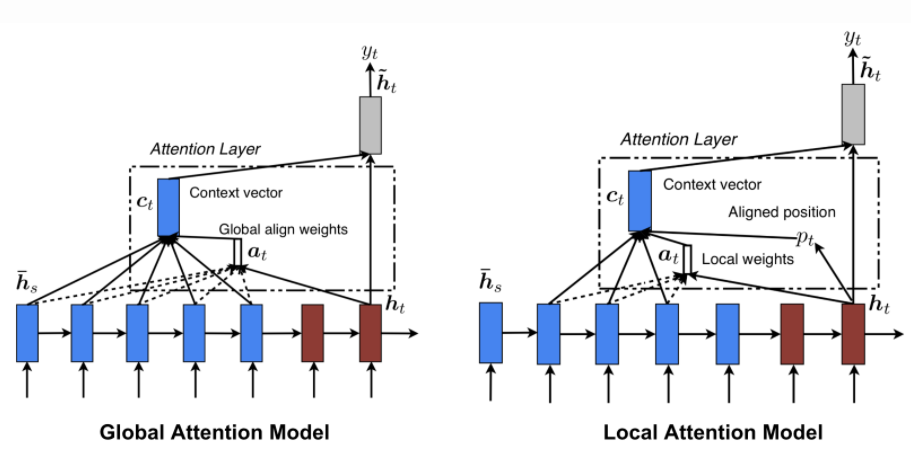

Pour prédire cette position $p_{t}$, deux méthodes sont proposées:

- *Monotonic alignement*: $p_{t}=t$

- *Predictive alignement*: $p_{t}= S \cdot sigmoid(v_{p}^{T}* tanh(W_{p}*h_{t})) $

Cela définit deux types d'attention locale: *local-m* et *local-p*.

Dans le cas de l'alignement prédictif, l'*alignement score* est ajusté un peu par une distribution gaussienne. Cela permet de favoriser les mots autour de ce point d'alignement. Cette méthode a l'avantage de résoudre le problème de différentiabilité de cette approche locale de l'attention.

En effet, ce type de découpage pour les méthodes attentionnels avait déjà été utilisé pour des problèmes de *captioning* par Xu et al. en 2015 dans leur article [Show, Attend and Tell: Neural Image Caption Generation with Visual Attention](https://arxiv.org/abs/1502.03044). 

Dans cette article, les auteurs proposent de faire appel à un mécanisme pour aider un réseau LSTM à savoir ou porter son attention avant de générer un mot pour le titre d'une image.

L'auteur propose ainsi deux mécanismes attentionnels:

-*Soft attention* qui est similaire à notre *global attention*

-*Hard attention* qui est une approche assez similaire à la *local attention* mais qui avait le mauvais gout d'être non différentiable.

Voici un exemple fourni dans l'article:

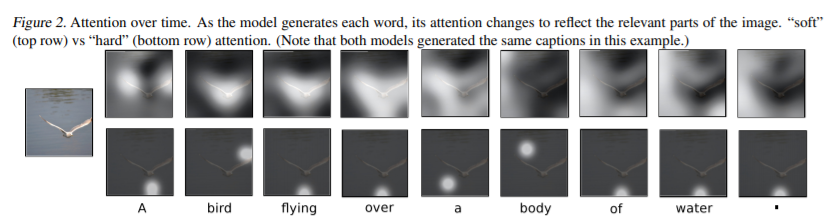

Cette image est une très bonne illustration de ce qu'il se passe également dans le cas de la *local attention* : le réseau ne porte attention qu'à l'intérieur d'une zone bien défini autour du point d'intérêt. On l'observe bien avec le mot *water* par exemple. 

En *soft attention*, presque toute l'image est importante sauf la mouette. En *hard attention*, seulement une petite partie de l'eau est repérée car le réseau n'a pas accès à toute l'image.

Cette technique de *local attention* ou *hard attention* a l'immense intérêt de réduire le nombre de calcul par rapport à la *global attention* ou *soft attention*.

Par ailleurs, le point noir de la *hard attention* était le caractère non différentiable qui nécessitait de faire appel à des techniques plus complexes pour l'entrainement. Ce problème semble résolu avec la *local-p attention*.

Voici les résultats obtenus par l'article selon plusieurs configurations:

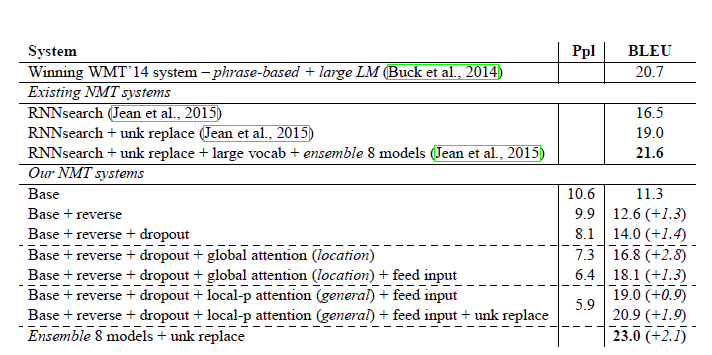

*unk replace*  ou *unknown replacement technique* fait référence à une technique de gestion des mots inconnus pour le réseau. Cette technique est par exemple développée dans [cette article](https://arxiv.org/abs/1410.8206).

Par exemple, une méthode assez basique est de remplacer le mot inconnu par le mot avec le poids attentionnel le plus élevé. 

Concernant une architecture optimal, les auteurs avouent ne pas avoir les ressources pour toutes les testées. Ils ont cependant pu en tester quelques une et nous livrent ainsi une table comparative des performances.

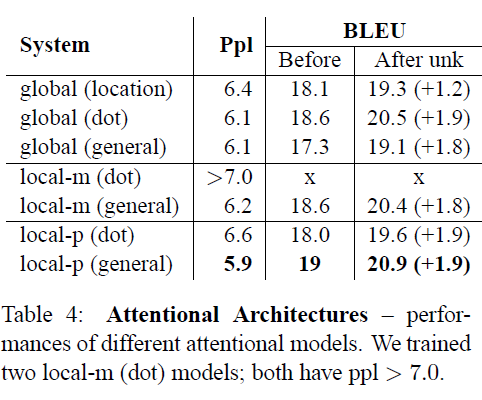

## Pour aller plus loin

Voici quelques ressources qui m'ont permis de mieux comprendre tous ces différents points détaillés dans le notebook mais dont je n'ai pas pu parler ici dans un soucis évident de concision:

- [Un cours donné dans le cadre du domaine Neuro-IA sur la modélisation de l'attention humaine puis sur ordinateur](https://lms.isae.fr/mod/resource/view.php?id=66873)

- [Un article excellent et très bien illustré par Jay Alammar (enocre) sur les seq2seq et l'attention](https://jalammar.github.io/visualizing-neural-machine-translation-mechanics-of-seq2seq-models-with-attention/), je recommande très vivement pour mieux comprendre tout cela.

- [Un article bien détaillé sur les différences entre l'attention de Bahdanau et Luong](https://blog.floydhub.com/attention-mechanism/) avec les formulations mathématiques et une implémentation en Pytorch. 

- [Un article très complet sur l'attention sous toutes ses formes et applications](https://lilianweng.github.io/lil-log/2018/06/24/attention-attention.html#global-vs-local-attention)

#### *Attention is all you need*

En 2017, une équipe de Google publie un papier qui a révolutionné pas mal de domaine de l'IA: [Attention is all you need](https://arxiv.org/abs/1706.03762)

Dans cet article, les auteurs proposent de supprimer toutes les cellules de RNN par des cellules de *self attention* et d'un réseau *feed forward*. La nouvelle architecture ainsi formée est appelé un **transformer**. Elle est toujours basée sur un Encoder/Decoder et n'est plus constitué que de cellules attentionnelles et de *feed forward network*.  

Cette architecture propose un avantage notable, mis à part des performances accrues:

- Il n'y a plus de RNN, l'architecture est donc complètement parallélisable. Ainsi les calculs peuvent être lancés sur plusieurs GPU en parallèle.

Voici un tableau comparatifs des performances (BLEU score) et du cout computationnel de différentes architectures tirée de ce même article:

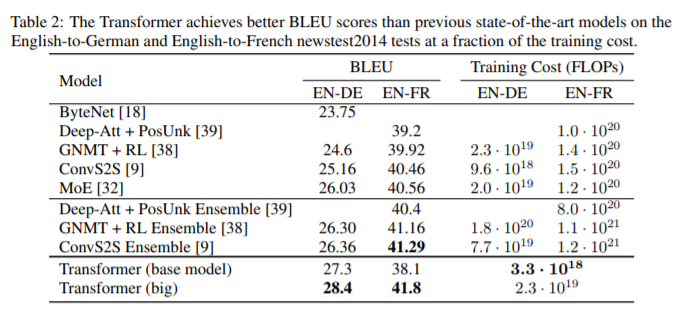

Voici à quoi ressemble l'architecture d'un transformer tel que décrit dans "Attention is all you need":

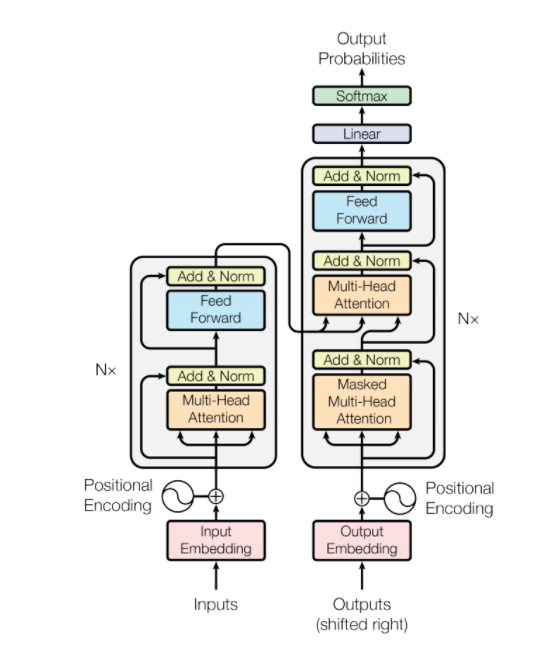

Pour une explication complète sur la structure et le fonctionnement des transformers, je recommande l'excellent article de Jay Alammar [ici](http://jalammar.github.io/illustrated-transformer/).

[Voici](https://pypi.org/project/transformers/) une librairie proposant des modèles de Transformers déjà entrainé, si vous voulez faire des tests, ou l'utiliser pour vos applications.

In [51]:
!pip install transformers

     |████████████████████████████████| 1.5MB 12.8MB/s 
     |████████████████████████████████| 890kB 56.8MB/s 
     |████████████████████████████████| 2.9MB 56.6MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893261 sha256=0482707775cb3144b19414a3e9a4ba862aa2743a66cbb109b4f13966ef76b7b1
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


In [52]:
from transformers import AutoTokenizer, AutoModelForCausalLM

transformer_model="distilgpt2" #Modèle voulu, il faut l'importer avant de l'utiliser évidemment

#Liste des modèles: https://huggingface.co/models

tokenizer = AutoTokenizer.from_pretrained(transformer_model)
model = AutoModelForCausalLM.from_pretrained(transformer_model, output_hidden_states=True)

In [54]:
text = "A thinking machine is"

# Tokenize the input string
input = tokenizer.encode(text, return_tensors="pt")

# Run the model
i=0
output = model.generate(input, max_length= len(input[0])+i, do_sample=False)

while ((tokenizer.decode(output[0][-1])!='.') and (i<20)):
  i+=1
  output = model.generate(input, max_length= len(input[0])+i, do_sample=False)
# Print the output
print('\n',tokenizer.decode(output[0]))

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.



 A thinking machine is a good idea.
